In [1]:
import warnings
warnings.filterwarnings('ignore')

# data wrangling & pre-processing
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

#model validation
from sklearn.metrics import log_loss,roc_auc_score,precision_score,f1_score,recall_score,roc_curve,auc
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,fbeta_score,matthews_corrcoef
from sklearn import metrics

# cross validation
from sklearn.model_selection import StratifiedKFold

# machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC 
import xgboost as xgb

from scipy import stats
from sklearn.metrics import mean_squared_error


In [2]:
dt = pd.read_csv("csv\heart_statlog_cleveland_hungary_final.csv")

In [3]:
# renaming features to proper name
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope','target']

In [4]:
# converting features to categorical features 

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'



dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'



dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt["sex"] = dt.sex.apply(lambda  x:'male' if x==1 else 'female')

In [5]:
dt['chest_pain_type'].value_counts()
dt['rest_ecg'].value_counts()
dt['st_slope'].value_counts()

flat           582
upsloping      526
downsloping     81
0                1
Name: st_slope, dtype: int64

In [6]:
#dropping row with st_slope =0
dt.drop(dt[dt.st_slope ==0].index, inplace=True)
#checking distribution
dt['st_slope'].value_counts()

flat           582
upsloping      526
downsloping     81
Name: st_slope, dtype: int64

In [7]:
## Checking missing entries in the dataset columnwise
dt.isna().sum()

age                        0
sex                        0
chest_pain_type            0
resting_blood_pressure     0
cholesterol                0
fasting_blood_sugar        0
rest_ecg                   0
max_heart_rate_achieved    0
exercise_induced_angina    0
st_depression              0
st_slope                   0
target                     0
dtype: int64

In [8]:
dt.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,target
0,40,male,atypical angina,140,289,0,normal,172,0,0.0,upsloping,0
1,49,female,non-anginal pain,160,180,0,normal,156,0,1.0,flat,1
2,37,male,atypical angina,130,283,0,ST-T wave abnormality,98,0,0.0,upsloping,0
3,48,female,asymptomatic,138,214,0,normal,108,1,1.5,flat,1
4,54,male,non-anginal pain,150,195,0,normal,122,0,0.0,upsloping,0


In [9]:
dt.describe(include =[np.number])

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,target
count,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000
mean,53.708158,132.138772,210.376787,0.212784,139.739277,0.387721,0.923549,0.528175
std,9.352961,18.369251,101.462185,0.409448,25.527386,0.487435,1.086464,0.499416
min,28.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,120.000000,188.000000,0.000000,121.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,229.000000,0.000000,141.000000,0.000000,0.600000,1.000000
75%,60.000000,140.000000,270.000000,0.000000,160.000000,1.000000,1.600000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


In [10]:
# Assuming you have a DataFrame called 'df' with categorical columns
categorical_columns = dt.select_dtypes(include=[object])

# Get summary statistics for categorical columns
summary_statistics = categorical_columns.describe()

# Display the summary statistics
print(summary_statistics)

         sex chest_pain_type rest_ecg st_slope
count   1189            1189     1189     1189
unique     2               4        3        3
top     male    asymptomatic   normal     flat
freq     908             625      683      582


In [11]:
# removing outliers
dt_numeric = dt[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved']]
z = np.abs(stats.zscore(dt_numeric))
dt = dt[(z < 3).all(axis=1)]
dt.shape


(1172, 12)

In [12]:
dt = pd.get_dummies(dt, drop_first=True)
X = dt.drop(['target'],axis=1)
y = dt['target']

<Axes: title={'center': 'Correlation with target'}>

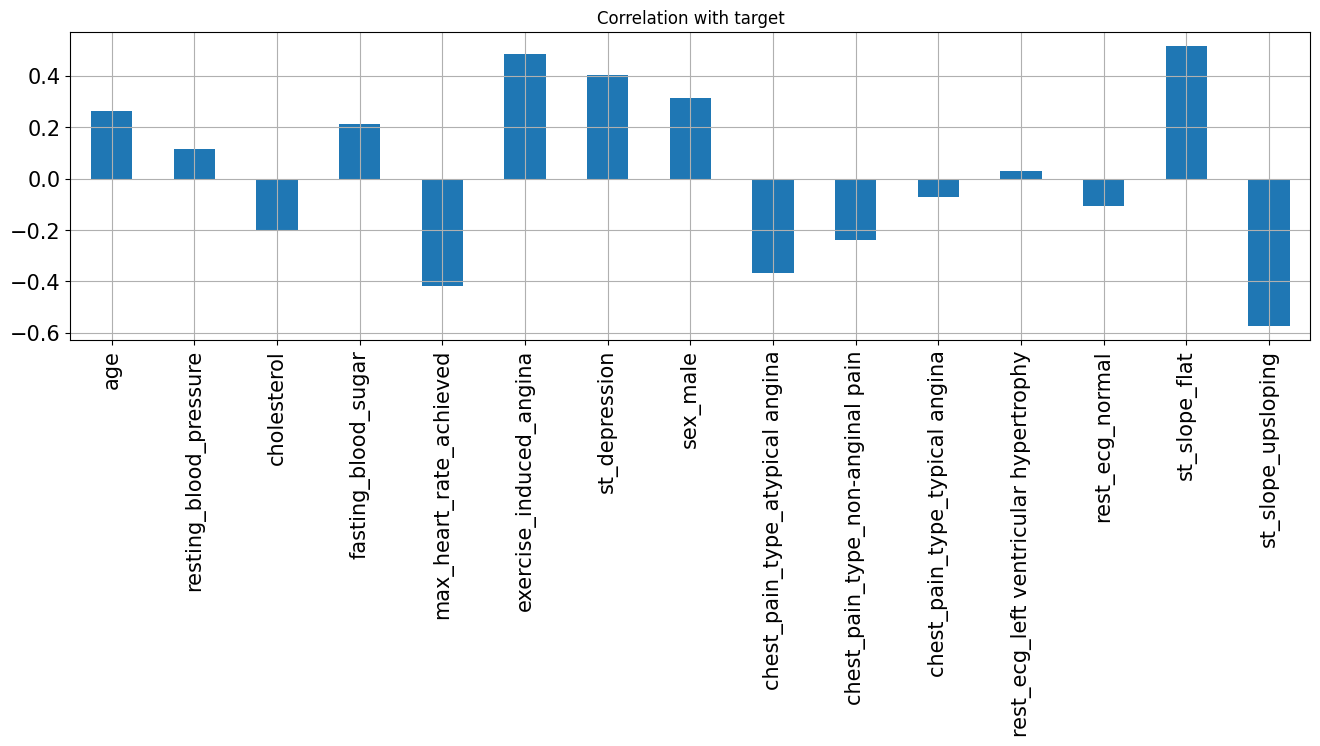

In [13]:
#Correlation with Response Variable class

X.corrwith(y).plot.bar(
        figsize = (16, 4), title = "Correlation with target", fontsize = 15,
        rot = 90, grid = True)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [15]:
## checking distribution of traget variable in train test split
print('Distribution of traget variable in training set')
print(y_train.value_counts())

print('Distribution of traget variable in test set')
print(y_test.value_counts())

Distribution of traget variable in training set
1    491
0    446
Name: target, dtype: int64
Distribution of traget variable in test set
1    123
0    112
Name: target, dtype: int64


In [16]:

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(937, 15)
(937,)
(235, 15)
(235,)


In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.fit_transform(X_train[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']])
X_train.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
478,0.673469,0.193548,0.000000,1,0.303704,1,0.454545,1,0,0,0,0,1,0,0
253,0.673469,0.354839,0.594705,0,0.355556,1,0.194805,1,0,0,0,0,0,0,1
273,0.551020,0.516129,0.409369,0,0.466667,1,0.584416,1,0,0,0,0,1,1,0
111,0.591837,0.623656,0.519348,0,0.185185,1,0.584416,1,0,0,0,0,1,1,0
50,0.448980,0.408602,0.474542,0,0.400000,1,0.454545,1,0,0,0,0,1,1,0


In [18]:
X_test[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.transform(X_test[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']])
X_test.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
1024,0.693878,0.301075,0.572301,0,0.266667,0,0.376623,1,1,0,0,1,0,1,0
182,0.469388,0.408602,0.456212,0,0.614815,0,0.194805,1,1,0,0,0,1,0,1
785,0.346939,0.494624,0.480652,0,0.629630,1,0.220779,0,0,0,0,1,0,1,0
924,0.591837,0.623656,0.562118,0,0.333333,1,0.272727,1,0,0,0,1,0,1,0
780,0.612245,0.387097,0.527495,0,0.466667,1,0.584416,1,0,0,0,1,0,1,0


# Model Building 

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf_ent = RandomForestClassifier(criterion='entropy',n_estimators=100)
rf_ent.fit(X_train, y_train)
y_pred_rfe = rf_ent.predict(X_test)
len(y_pred_rfe)

235

In [20]:
# Multi Layer Perceptron
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
y_pred_mlp = mlp.predict(X_test)

In [21]:
### K nearest neighbour (n=9)
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(9)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

In [22]:
et_100 = ExtraTreesClassifier(n_estimators= 100)
et_100.fit(X_train,y_train)
y_pred_et_100 = et_100.predict(X_test)

In [23]:
import xgboost as xgb
xgb = xgb.XGBClassifier(n_estimators= 500)
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

In [24]:
svc = SVC(kernel='linear',gamma='auto',probability=True)
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)

In [25]:
sgd = SGDClassifier(max_iter=1000, tol=1e-4)
sgd.fit(X_train,y_train)
y_pred_sgd = sgd.predict(X_test)

In [26]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
y_pred_ada = ada.predict(X_test)

In [27]:
decc = DecisionTreeClassifier()
decc.fit(X_train,y_train)
y_pred_decc = decc.predict(X_test)

In [28]:
gbm = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbm.fit(X_train,y_train)
y_pred_gbm = gbm.predict(X_test)

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef,RMSE
0,Random Forest,0.897872,0.866667,0.95122,0.839286,0.906977,0.895253,3.681054,0.798545,0.319574


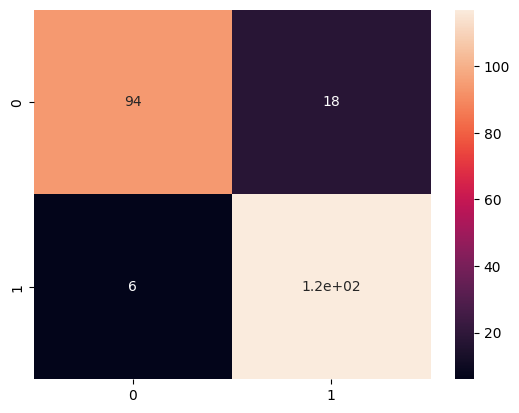

In [29]:
CM=confusion_matrix(y_test,y_pred_rfe)
sns.heatmap(CM, annot=True)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
loss_log = log_loss(y_test, y_pred_rfe)
acc= accuracy_score(y_test, y_pred_rfe)
roc=roc_auc_score(y_test, y_pred_rfe)
prec = precision_score(y_test, y_pred_rfe)
rec = recall_score(y_test, y_pred_rfe)
f1 = f1_score(y_test, y_pred_rfe)
mathew = matthews_corrcoef(y_test, y_pred_rfe)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfe))
model_results =pd.DataFrame([['Random Forest',acc, prec,rec,specificity, f1,roc, loss_log,mathew,rmse]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef','RMSE'])

model_results


In [30]:
data = {        'MLP': y_pred_mlp, 
                'KNN': y_pred_knn, 
                'EXtra tree classifier': y_pred_et_100,
                'XGB': y_pred_xgb, 
                'SVC': y_pred_svc, 
                'SGD': y_pred_sgd,
                'Adaboost': y_pred_ada, 
                'CART': y_pred_decc, 
                'GBM': y_pred_gbm }

models = pd.DataFrame(data) 
 
for column in models:
    CM=confusion_matrix(y_test,models[column])
    
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    specificity = TN/(TN+FP)
    loss_log = log_loss(y_test, models[column])
    acc= accuracy_score(y_test, models[column])
    roc=roc_auc_score(y_test, models[column])
    prec = precision_score(y_test, models[column])
    rec = recall_score(y_test, models[column])
    f1 = f1_score(y_test, models[column])
    rmse = np.sqrt(mean_squared_error(y_test,models[column]))
    mathew = matthews_corrcoef(y_test, models[column])
    results =pd.DataFrame([[column,acc, prec,rec,specificity, f1,roc, loss_log,mathew,rmse]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef','RMSE'])
    model_results = model_results.append(results, ignore_index = True)

model_results


,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef,RMSE
0,Random Forest,0.897872,0.866667,0.951220,0.839286,0.906977,0.895253,3.681054,0.798545,0.319574
1,MLP,0.825532,0.788732,0.910569,0.732143,0.845283,0.821356,6.288467,0.656436,0.417694
2,KNN,0.808511,0.786765,0.869919,0.741071,0.826255,0.805495,6.901976,0.618029,0.437595
3,EXtra tree classifier,0.893617,0.876923,0.926829,0.857143,0.901186,0.891986,3.834431,0.787582,0.326164
4,XGB,0.893617,0.865672,0.943089,0.839286,0.902724,0.891188,3.834431,0.789339,0.326164
5,SVC,0.825532,0.801471,0.886179,0.758929,0.841699,0.822554,6.288467,0.652539,0.417694
6,SGD,0.800000,0.779412,0.861789,0.732143,0.818533,0.796966,7.208731,0.600774,0.447214
7,Adaboost,0.834043,0.813433,0.886179,0.776786,0.848249,0.831482,5.981713,0.668866,0.407379
8,CART,0.829787,0.821705,0.861789,0.794643,0.841270,0.828216,6.135090,0.658875,0.412568
9,GBM,0.851064,0.828358,0.902439,0.794643,0.863813,0.848541,5.368204,0.703286,0.385922


<Axes: >

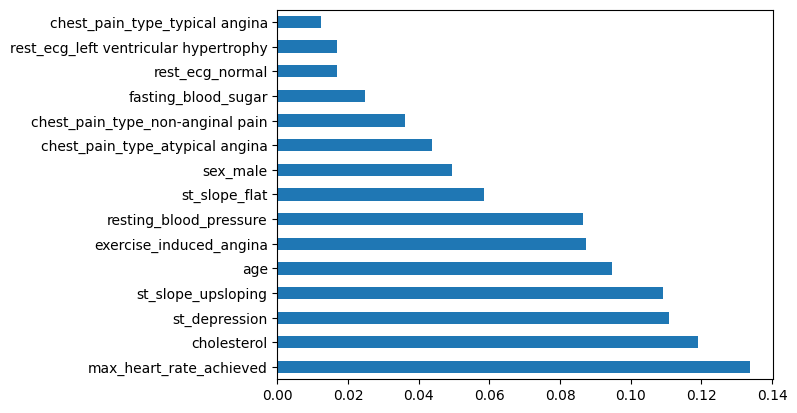

In [35]:
feat_importances = pd.Series(rf_ent.feature_importances_, index=X_train.columns)
feat_importances_2 = pd.Series( et_100.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
